In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [2]:
import quandl

In [11]:
bitcoin = quandl.get("BCHAIN/MKPRU")

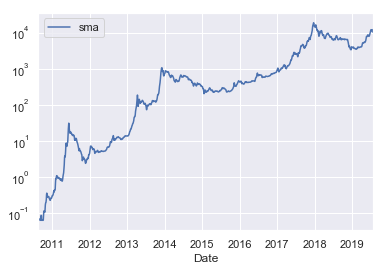

In [12]:
bitcoin.columns = ['Close']
bitcoin['Close'].replace(0, np.nan, inplace=True)
bitcoin['sma'] = bitcoin['Close'].rolling(window=5).mean()
bitcoin['log'] = np.log(bitcoin['sma'])
bitcoin = bitcoin.dropna()
bitcoin[['sma']].plot(logy=True);
plt.legend();

In [22]:
bitcoin['Returns'] = (bitcoin['sma'].pct_change() + 1).fillna(1)
bitcoin.head()

,Close,sma,log,Returns
Date,,,,
2010-08-21,0.066899,0.070660,-2.649878,1.000000
2010-08-22,0.066400,0.068560,-2.680049,0.970280
2010-08-23,0.066000,0.066960,-2.703663,0.976663
2010-08-24,0.066889,0.066578,-2.709387,0.994292
2010-08-25,0.066500,0.066538,-2.709988,0.999399


In [23]:
bitcoin.tail()

,Close,sma,log,Returns
Date,,,,
2019-07-19,10092.751667,10253.824000,9.235406,0.974911
2019-07-20,10455.730000,10174.384667,9.227629,0.992253
2019-07-21,10685.415000,10223.756833,9.232469,1.004853
2019-07-22,10569.305000,10277.535500,9.237716,1.005260
2019-07-23,10449.626667,10450.565667,9.254411,1.016836


In [24]:
[x for x in bitcoin.Returns.tail(8) - 1]

[-0.03840191226873213,
 -0.022567118386025986,
 -0.03651808410467172,
 -0.025088616107349693,
 -0.007747288556912868,
 0.004852594852410075,
 0.0052601668385339195,
 0.0168357644372914]

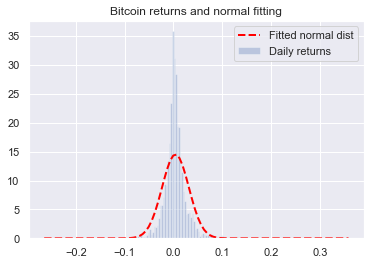

In [25]:
# Trying to fit the returns to a normal distribution 

from scipy.stats import norm

parameters = norm.fit(bitcoin.Returns - 1)

# now, parameters[0] and parameters[1] are the mean and 
# the standard deviation of the fitted distribution
x = np.linspace(min(bitcoin.Returns - 1), max(bitcoin.Returns - 1), 100)

# Generate the pdf (fitted distribution)
fitted_pdf = norm.pdf(x,loc = parameters[0],scale = parameters[1])
# Generate the pdf (normal distribution non fitted)
normal_pdf = norm.pdf(x)

# Type help(plot) for a ton of information on pyplot
plt.plot(x,fitted_pdf,"red",label="Fitted normal dist",linestyle="dashed", linewidth=2)
# plt.plot(x,normal_pdf,"blue",label="Normal dist", linewidth=2)
plt.hist(bitcoin.Returns - 1,normed=1,color="b",alpha=.3, bins=200, label='Daily returns') #alpha, from 0 (transparent) to 1 (opaque)
plt.title("Bitcoin returns and normal fitting")
# insert a legend in the plot (using label)
plt.legend()
# plt.yscale('log')
plt.show()

In [26]:
import datetime

In [27]:
datetime.date.today()

datetime.date(2019, 7, 24)

In [36]:
strdate = 'Dec 31st 2020'
index_future = pd.date_range(start=datetime.date.today(), end='2020-12-30')
index_future.shape

(526,)

In [29]:
np.random.seed(1234)
simulated_returns_bitcoin = np.random.choice(bitcoin.Returns, size=(len(index_future), 400000))
sim_bitcoin_returns = pd.DataFrame(data=simulated_returns_bitcoin, index=index_future)
# sim_bitcoin_returns

In [30]:
cum_sim_bitcoin = sim_bitcoin_returns.cumprod(axis=0)
cum_sim_bitcoin.shape

(526, 400000)

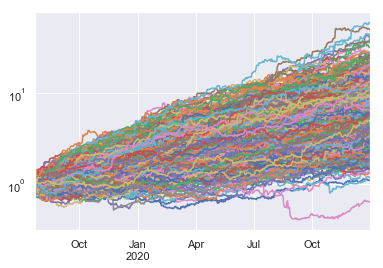

In [31]:
cum_sim_bitcoin.iloc[:, :1000].plot(legend=False, logy=True)
# plt.legend(False)

In [32]:
future = pd.DataFrame(data=cum_sim_bitcoin, index=index_future)
future = future * bitcoin['Close'][-1]

In [33]:
possible_prices = future.iloc[-1, :]
possible_prices.name = 'Possible price'

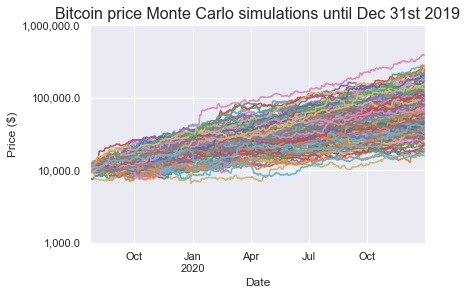

In [34]:
future.iloc[:, :200].plot(legend=False, logy=True, grid=True);
yticks = plt.yticks()[0][1:-1]
yticks = np.logspace(3, 6, 4)
plt.yticks(yticks, ['{:,}'.format(t) for t in yticks])
plt.title('Bitcoin price Monte Carlo simulations until '+strdate, size=16)
plt.ylabel('Price ($)', size=12)
plt.xlabel('Date', size=12);
# plt.ylim(min(np.log10(future.iloc[:, :1000])), max(np.log10(future.iloc[:, :1000])))

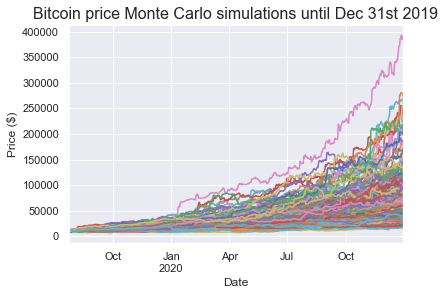

In [35]:
future.iloc[:, :200].plot(legend=False, logy=False, grid=True);
plt.title('Bitcoin price Monte Carlo simulations until '+strdate, size=16)
plt.ylabel('Price ($)', size=12)
plt.xlabel('Date', size=12);

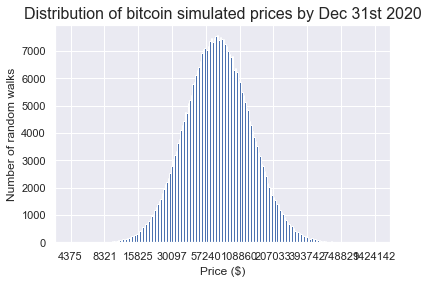

In [37]:
y, x, _ = plt.hist(np.log(possible_prices), bins=200);
xticks = plt.xticks()
ticks = np.linspace(min(np.log(possible_prices)), max(np.log(possible_prices)), 10)
plt.xticks(ticks, [str(int(np.exp(tick))) for tick in ticks]);

plt.xlabel('Price ($)')
plt.ylabel('Number of random walks')
plt.title('Distribution of bitcoin simulated prices by '+strdate, size=16);

In [39]:
from scipy.stats import gaussian_kde

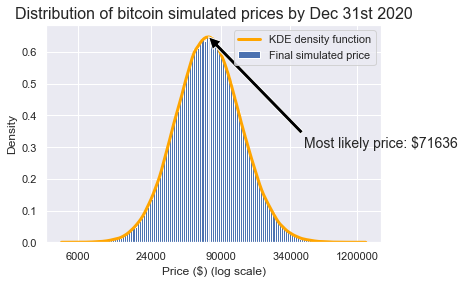

In [40]:
# More logical ticks


# Plot histogram of final simulated prices
fig, ax = plt.subplots()
ax.hist(np.log(possible_prices), bins=150, density=True, label='Final simulated price');
xticks = plt.xticks()
hand_ticks = [100, 400, 1700, 6000, 24000, 90000, 340000, 1200000, 5000000, 18000000]
# plt.xticks(np.log(hand_ticks), [str(tick) for tick in hand_ticks]);
ax.set_xticks(np.log(hand_ticks))
ax.set_xticklabels([str(tick) for tick in hand_ticks])

# Plot KDE function
kde = gaussian_kde(np.log(possible_prices))
x = np.linspace(min(np.log(possible_prices)), max(np.log(possible_prices)), num=150) #bins)
ax.plot(x, kde.pdf(x), linewidth=3, c='orange', alpha=1, label='KDE density function')

# Plot vertical line at the most likely price
most_likely_price = np.exp(x[np.argmax(kde.pdf(x))])
# most_likely_price = possible_prices.quantile(0.5)
ax.vlines(np.log(most_likely_price), 0, kde.pdf(np.log(most_likely_price)), color='w')

# Draw annotation
ax.annotate('Most likely price: ${}'.format(int(round(most_likely_price))), 
            xy=(np.log(most_likely_price), kde.pdf(np.log(most_likely_price))), 
            xytext=(13, 0.3),
            arrowprops=dict(facecolor='black', shrink=0.0),
            size=14)

plt.legend()

plt.xlabel('Price ($) (log scale)', size=12)
plt.ylabel('Density', size=12)
plt.title('Distribution of bitcoin simulated prices by '+strdate, size=16)


plt.show()

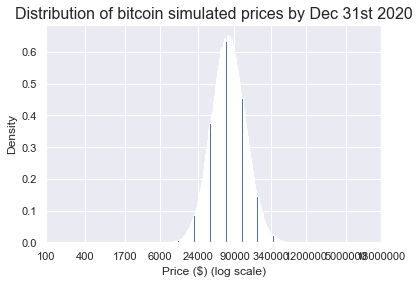

In [41]:
# More logical ticks

fig, ax = plt.subplots()
ax.hist(np.log(possible_prices), bins=150, density=True);
xticks = plt.xticks()
hand_ticks = [100, 400, 1700, 6000, 24000, 90000, 340000, 1200000, 5000000, 18000000]
# plt.xticks(np.log(hand_ticks), [str(tick) for tick in hand_ticks]);
ax.set_xticks(np.log(hand_ticks))
ax.set_xticklabels([str(tick) for tick in hand_ticks])

# # Plot KDE function
# kde = gaussian_kde(np.log(possible_prices))
# x = np.linspace(min(np.log(possible_prices)), max(np.log(possible_prices)), bins)
# ax.plot(x, kde.pdf(x), linewidth=2, c='orange', alpha=1)

# # # Plot vertical line at the most likely price
# most_likely_price = np.exp(x[np.argmax(kde.pdf(x))])
# # most_likely_price = possible_prices.quantile(0.5)
# ax.vlines(np.log(most_likely_price), 0, kde.pdf(np.log(most_likely_price)), color='w')

# # Draw annotation
# ax.annotate('Most likely price: ${}'.format(int(round(most_likely_price))), 
#             xy=(np.log(most_likely_price), kde.pdf(np.log(most_likely_price))), 
#             xytext=(13, 0.3),
#             arrowprops=dict(facecolor='black', shrink=0.0),
#             size=14)


plt.xlabel('Price ($) (log scale)', size=12)
plt.ylabel('Density', size=12)
plt.title('Distribution of bitcoin simulated prices by '+strdate, size=16)


plt.show()

In [42]:
most_likely_price

71635.5873776429

In [43]:
possible_prices.quantile(0.5)

71055.03088175105

In [44]:
possible_prices.quantile(0.05)

26052.124540726305

In [45]:
possible_prices.quantile(0.95)

198826.0718465935

In [46]:
# 80% confidence interval

possible_prices.quantile(.1), possible_prices.quantile(.9)

(32515.20776696133, 157876.9399428314)

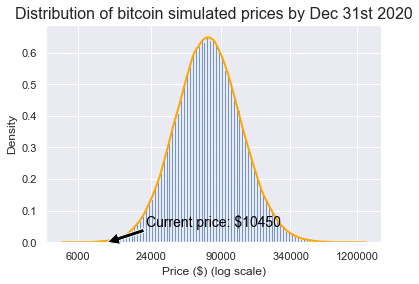

In [47]:
# More logical ticks

fig, ax = plt.subplots()
ax.hist(np.log(possible_prices), bins=200, density=True, alpha=0.7);
xticks = plt.xticks()
hand_ticks = [100, 400, 1700, 6000, 24000, 90000, 340000, 1200000, 5000000, 18000000]
# plt.xticks(np.log(hand_ticks), [str(tick) for tick in hand_ticks]);
ax.set_xticks(np.log(hand_ticks))
ax.set_xticklabels([str(tick) for tick in hand_ticks])

# Plot KDE function
kde = gaussian_kde(np.log(possible_prices))
x = np.linspace(min(np.log(possible_prices)), max(np.log(possible_prices)), num=200)
ax.plot(x, kde.pdf(x), linewidth=2, c='orange', alpha=1)

# Plot vertical line at today's price
current_price = bitcoin.Close[-1]
ax.vlines(np.log(current_price), 0, kde.pdf(np.log(current_price)), color='w')

# Draw annotation
ax.annotate('Current price: ${}'.format(int(round(current_price))), 
            xy=(np.log(current_price), 0), 
            xytext=(10, 0.05),
            arrowprops=dict(facecolor='black', shrink=0.0),
            size=14, 
            color='black')

# Plot area below current price
x_fill = np.linspace(min(np.log(possible_prices)), np.log(current_price), num=200)
ax.fill_between(x_fill, kde.pdf(x_fill), color='black')


plt.xlabel('Price ($) (log scale)', size=12)
plt.ylabel('Density', size=12)
plt.title('Distribution of bitcoin simulated prices by '+strdate, size=16)

plt.show()

In [48]:
# Probability that bitcoin's price is lower than today's by the end of the year

kde.integrate_box(0, np.log(bitcoin.Close[-1])) * 100

0.08724214520781873

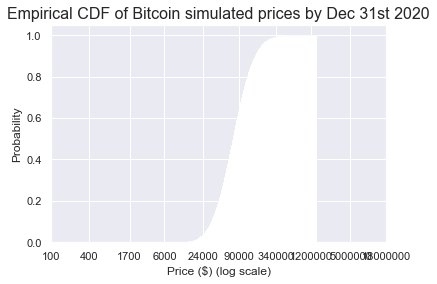

In [49]:
# More logical ticks

fig, ax = plt.subplots()
ax.hist(np.log(possible_prices), bins=2000, density=True, cumulative=True);
xticks = plt.xticks()
hand_ticks = [100, 400, 1700, 6000, 24000, 90000, 340000, 1200000, 5000000, 18000000]
# plt.xticks(np.log(hand_ticks), [str(tick) for tick in hand_ticks]);
ax.set_xticks(np.log(hand_ticks))
ax.set_xticklabels([str(tick) for tick in hand_ticks])


# # Plot vertical line at the most likely price
# most_likely_price = np.exp(x[np.argmax(kde.pdf(x))])
# ax.vlines(np.log(most_likely_price), 0, kde.pdf(np.log(most_likely_price)), color='w')

# # Draw annotation
# ax.annotate('Most likely price: ${} per bitcoin'.format(int(round(most_likely_price))), 
#             xy=(np.log(most_likely_price), kde.pdf(np.log(most_likely_price))), 
#             xytext=(13, 0.3),
#             arrowprops=dict(facecolor='black', shrink=0.0),
#             size=14)


plt.xlabel('Price ($) (log scale)', size=12)
plt.ylabel('Probability', size=12)
plt.title('Empirical CDF of Bitcoin simulated prices by '+strdate, size=16)

plt.show()

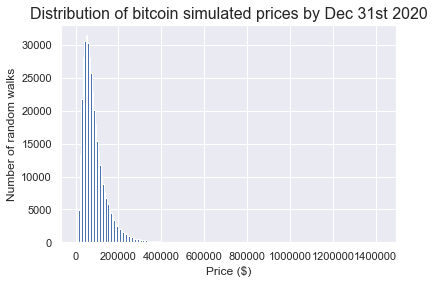

In [50]:
fig, ax = plt.subplots()
ax.hist(possible_prices, bins=200, density=False);
# xticks = plt.xticks()
# hand_ticks = [100, 400, 1700, 6000, 24000, 90000, 340000, 1200000, 5000000, 18000000]
# # plt.xticks(np.log(hand_ticks), [str(tick) for tick in hand_ticks]);
# ax.set_xticks(np.log(hand_ticks))
# ax.set_xticklabels([str(tick) for tick in hand_ticks])

# kde = gaussian_kde(np.log(possible_prices))
# x = np.linspace(min(np.log(possible_prices)), max(np.log(possible_prices)), bins)
# ax.plot(x, kde.pdf(x))


plt.xlabel('Price ($)', size=12)
plt.ylabel('Number of random walks', size=12)
plt.title('Distribution of bitcoin simulated prices by '+strdate, size=16)

plt.show()

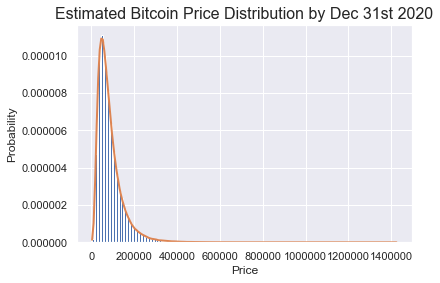

In [51]:
from scipy import stats
kde = stats.gaussian_kde(possible_prices)

fig, ax = plt.subplots(1, 1)

bins = 200

ax.hist(possible_prices, bins=bins, density=True);

xd = np.linspace(min(possible_prices)-10, max(possible_prices)+10, num=bins)
ax.plot(xd, kde.pdf(xd), linewidth=2);

ax.set_xlabel('Price', size=12)
ax.set_ylabel('Probability', size=12)
ax.set_title('Estimated Bitcoin Price Distribution by '+strdate, size=16);